In [165]:
from discretize import TensorMesh, CylMesh
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
from simpegaem import SimulationAEM
%matplotlib inline

In [166]:
# cell size, number of cells in the x-direction, 
# number of cells in the z-direction and number of padding cells
mesh_type = '2d_cyl'

if mesh_type== '2d_cyl':
    ncx = 10
    csx = 10.
    npadx = 20.
    ncz = 10.
    csz = 5.
    npadz = 18.
    hx = [(csx, ncx), (csx, npadx, 1.3)]
    hz = [(csz, npadz, -1.3), (csz, ncx), (csz, npadz, 1.3)]    
    mesh = CylMesh([hx, 1, hz], x0='00C')
elif mesh_type == '3d_tensor':
    cs, ncx, npad = 10., 9, 8    
    ncy = 1
    ncz = 6
    hx = [(cs, npad, -1.3), (cs, ncx), (cs, npad, 1.3)]
    hy = [(cs, npad, -1.3), (cs, ncy), (cs, npad, 1.3)]    
    hz = [(cs, npad, -1.3), (cs, ncz), (cs, npad, 1.3)]
    mesh = TensorMesh([hx, hy, hz], 'CCC')
active = mesh.cell_centers[:,2] < 0.
sigma_background = 1./1000
sigma_layer = 1.
sigma = np.ones(mesh.n_cells)*1e-8
sigma[active] = sigma_background
ind_layer = np.logical_and(mesh.cell_centers[:,2]<-100., mesh.cell_centers[:,2]>-200.)
sigma[ind_layer] = sigma_layer
rho = 1./sigma

In [167]:
from matplotlib.colors import LogNorm

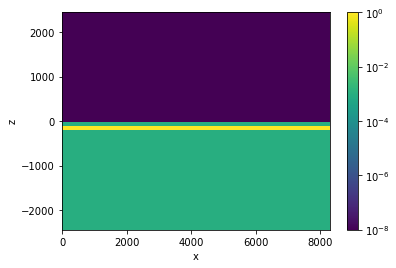

In [168]:
out = mesh.plot_image(sigma, pcolor_opts={'norm':LogNorm()})
plt.colorbar(out[0])

In [169]:
from SimPEG import utils
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG import maps
from pymatsolver import PardisoSolver
# from pymatsolver import Solver

In [170]:
receiver_orientation = "z"                    # "x", "y" or "z"
z_src = 30
x_rx = 10.
z_offset = 0.
receiver_location = np.array([x_rx, 0., z_src+z_offset])
source_location = np.array([0., 0., z_src])
times = np.logspace(np.log10(1e-6), np.log10(1e-2), 31)
rx = tdem.receivers.PointMagneticFluxTimeDerivative(
    receiver_location, times, orientation=receiver_orientation
)
receiver_list = [rx]
src = tdem.sources.MagDipole(
    receiver_list=receiver_list, location=source_location,
    waveform=tdem.sources.StepOffWaveform(), orientation='z'
)

# Survey
source_list = [src]
survey = tdem.Survey(source_list)
dts = np.diff(np.logspace(-7, -1, 60))
time_steps = []
for dt in dts:
    time_steps.append((dt, 1))

simulation_3d = SimulationAEM(
    mesh=mesh,
    survey=survey,
    sigmaMap=maps.IdentityMap(mesh),
    solver=PardisoSolver,
    time_steps=time_steps
)    
data = simulation_3d.dpred(sigma)

C:\Users\sgkan\Projects\pymatsolver\pymatsolver\direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
C:\Users\sgkan\Projects\pymatsolver\pymatsolver\direct.py:73: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


In [171]:
data

array([-6.95550670e-08, -4.07848823e-08, -2.35891795e-08, -1.33264007e-08,
       -7.10628504e-09, -3.43039903e-09, -1.52894216e-09, -5.79949389e-10,
       -1.67282877e-10, -3.64667397e-11, -1.07510133e-11, -8.50307423e-12,
       -9.49142032e-12, -9.55665306e-12, -9.15188287e-12, -8.57516850e-12,
       -7.85687607e-12, -7.01184967e-12, -6.05515109e-12, -5.01891046e-12,
       -3.98006234e-12, -3.01601884e-12, -2.21072627e-12, -1.60602771e-12,
       -1.17241407e-12, -8.71935267e-13, -6.56589673e-13, -4.81895567e-13,
       -3.36350106e-13, -2.22639913e-13, -1.36363386e-13])

In [172]:
# x = np.linspace(10, 100, 10)
# y = np.zeros_like(x)
# z = np.ones_like(x) * 30.
# Fz = mesh.getInterpolationMat(np.c_[x, y, z], locType='Fz')
# b0 = src.bInitial(prb)
# bz = Fz*b0
# bza = -1./(4*np.pi*x**3) * mu_0
# plt.semilogy(x, -bz/(np.pi/2), 'k-', )
# plt.semilogy(x, -bz, 'k--', )
# plt.semilogy(x, -bza, 'kx')

In [173]:
# Define the simulation
simulation = tdem.Simulation1DLayered(
    survey=survey,
    sigmaMap=maps.IdentityMap(nP=1),
)

# Predict data for a given model
sigma_1d =  np.ones(1) * sigma_background
data_analytic = simulation.dpred(sigma_1d)
data_analytic

array([-6.85002703e-08, -4.05940986e-08, -2.34511233e-08, -1.32274856e-08,
       -7.29735146e-09, -3.94484717e-09, -2.09355356e-09, -1.09275855e-09,
       -5.61970435e-10, -2.85213092e-10, -1.43072763e-10, -7.10364069e-11,
       -3.49536459e-11, -1.70641731e-11, -8.27354822e-12, -3.98756174e-12,
       -1.91196906e-12, -9.12608555e-13, -4.33929572e-13, -2.05651318e-13,
       -9.71631797e-14, -4.58006175e-14, -2.15480133e-14, -1.01102200e-14,
       -4.74042681e-15, -2.22145203e-15, -1.03641068e-15, -4.85378237e-16,
       -2.27449495e-16, -1.04700458e-16, -4.96788877e-17])

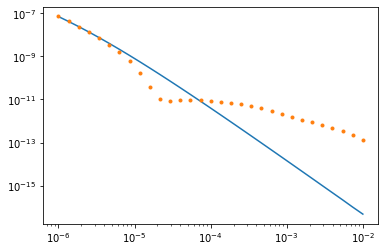

In [174]:
plt.loglog(times, -data_analytic)
plt.loglog(times, -data, '.')

In [175]:
# # %%time
# data_analytic, _, _ = aem_simulation(1./sigma_background, 1./sigma_background, 10, 10)

In [176]:
# plt.loglog(rx.times, -data/(np.pi/2.), 'kx')
# plt.loglog(rx.times, -data_analytic, 'k')
# plt.loglog(prb.times, np.ones(prb.times.size)*1e-11, 'k|')

In [177]:
b0 = src.bInitial(simulation_3d)

In [178]:
b0.shape

(2790,)

In [179]:
mesh.n_faces

2790

In [180]:
from scipy.interpolate import interp1d

In [181]:
def bdf1():
    # Operators
    C = mesh.edgeCurl
    Mfmui = mesh.getFaceInnerProduct(1./mu_0)
    MeSigma = mesh.getEdgeInnerProduct(sigma)
    n_steps = simulation_3d.time_steps.size
    Fz = mesh.getInterpolationMat(rx.locations, locType='Fz')
    eps = 1e-10
    def getA(dt):
        return C.T*Mfmui*C + 1./dt * MeSigma
    dt_0 = 0.
    data_test = np.zeros(simulation_3d.time_steps.size)
    sol_n0 = np.zeros(mesh.nE)
    sol_n1 = np.zeros(mesh.nE)

    for ii in range(n_steps):
        dt = simulation_3d.time_steps[ii]
        A = getA(dt)
        if abs(dt_0-dt) > eps:
            Ainv = simulation_3d.solver(A)
        if ii==0:        
            b0 = src.bInitial(simulation_3d)
            s_e = C.T*Mfmui*b0
            rhs = s_e/dt
        else:
            rhs = MeSigma*sol_n0/dt
        sol_n1 = Ainv*rhs
        data_test[ii] = Fz*(-C*sol_n1)
        dt_0 = dt
        sol_n0 = sol_n1.copy()    
    step_func = interp1d(
        np.log10(simulation_3d.time_mesh.gridCC[:]), data_test
    )
    return step_func(np.log10(rx.times))

In [182]:
def bdf2():
    # Operators
    C = mesh.edgeCurl
    Mfmui = mesh.getFaceInnerProduct(1./mu_0)
    MeSigma = mesh.getEdgeInnerProduct(sigma)
    n_steps = simulation_3d.time_steps.size
    Fz = mesh.getInterpolationMat(rx.locations, locType='Fz')
    eps = 1e-10
    def getA(dt, factor=1.):
        return C.T*Mfmui*C + factor/dt * MeSigma
    dt_0 = 0.
    data_test = np.zeros(simulation_3d.time_steps.size)
    sol_n0 = np.zeros(mesh.nE)
    sol_n1 = np.zeros(mesh.nE)
    sol_n2 = np.zeros(mesh.nE)
    for ii in range(n_steps):
        dt = simulation_3d.time_steps[ii]
        #Factor for BDF2
        factor=3/2.            
        if abs(dt_0-dt) > eps:
            print (ii, factor)
            A = getA(dt, factor=factor)            
            Ainv = simulation_3d.solver(A)
        if ii==0:        
            b0 = src.bInitial(simulation_3d)
            s_e = C.T*Mfmui*b0
            rhs = factor/dt*s_e
        elif ii==1:
            rhs = -factor/dt*(MeSigma*(-4/3.*sol_n1+1/3.*sol_n0) + 1./3.*s_e)
        else:
            rhs = -factor/dt*(MeSigma*(-4/3.*sol_n1+1/3.*sol_n0))
        sol_n2 = Ainv*rhs
        data_test[ii] = Fz*(-C*sol_n2)
        dt_0 = dt
        sol_n0 = sol_n1.copy()            
        sol_n1 = sol_n2.copy()    
    step_func = interp1d(
        np.log10(simulation_3d.time_mesh.gridCC[:]), data_test
    )
    return step_func(np.log10(rx.times))

In [183]:
temp1 = bdf1()

C:\Users\sgkan\Projects\pymatsolver\pymatsolver\direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
C:\Users\sgkan\Projects\pymatsolver\pymatsolver\direct.py:73: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


In [184]:
temp2 = bdf2()

0 1.5
1 1.5
2 1.5
3 1.5
4 1.5
5 1.5
6 1.5
7 1.5
8 1.5
9 1.5
10 1.5
11 1.5
12 1.5
13 1.5
14 1.5
15 1.5
16 1.5
17 1.5
18 1.5
19 1.5
20 1.5
21 1.5
22 1.5
23 1.5
24 1.5
25 1.5
26 1.5
27 1.5
28 1.5
29 1.5
30 1.5
31 1.5
32 1.5
33 1.5
34 1.5
35 1.5
36 1.5
37 1.5
38 1.5
39 1.5
40 1.5
41 1.5
42 1.5
43 1.5
44 1.5
45 1.5
46 1.5
47 1.5
48 1.5
49 1.5
50 1.5
51 1.5
52 1.5
53 1.5
54 1.5
55 1.5
56 1.5
57 1.5
58 1.5


In [185]:
data_analytic

array([-6.85002703e-08, -4.05940986e-08, -2.34511233e-08, -1.32274856e-08,
       -7.29735146e-09, -3.94484717e-09, -2.09355356e-09, -1.09275855e-09,
       -5.61970435e-10, -2.85213092e-10, -1.43072763e-10, -7.10364069e-11,
       -3.49536459e-11, -1.70641731e-11, -8.27354822e-12, -3.98756174e-12,
       -1.91196906e-12, -9.12608555e-13, -4.33929572e-13, -2.05651318e-13,
       -9.71631797e-14, -4.58006175e-14, -2.15480133e-14, -1.01102200e-14,
       -4.74042681e-15, -2.22145203e-15, -1.03641068e-15, -4.85378237e-16,
       -2.27449495e-16, -1.04700458e-16, -4.96788877e-17])

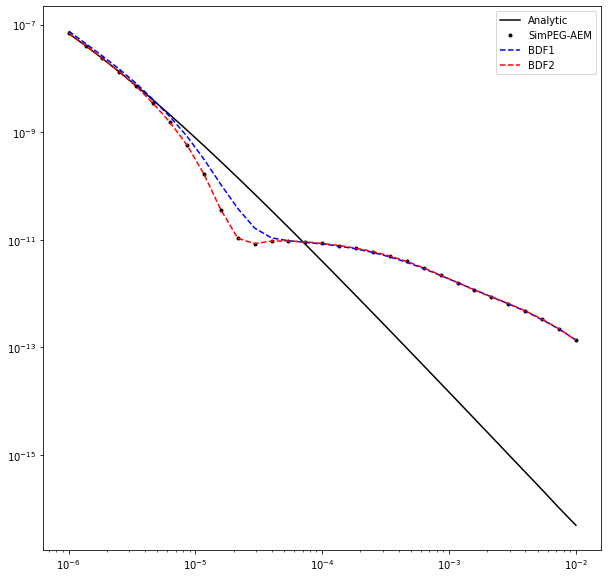

In [186]:
plt.figure(figsize = (10, 10))
plt.loglog(rx.times, -data_analytic, 'k')
plt.loglog(rx.times, -data, 'k.')
plt.loglog(rx.times, -temp1, 'b--')
plt.loglog(rx.times, -temp2, 'r--')
plt.legend(("Analytic", "SimPEG-AEM", "BDF1", "BDF2"))

In [187]:
np.sqrt(abs((data_analytic-temp1)/data_analytic)**2).mean()

289.5046344056027

In [188]:
np.sqrt(abs((data_analytic-temp2)/data_analytic)**2).mean()

291.1760061341364

In [189]:
np.sqrt(abs((data_analytic-data)/data_analytic)**2).mean()

291.17600613413646

In [190]:
import geoana
print (geoana.__version__)

0.4.0


In [191]:
import SimPEG

In [192]:
SimPEG.__version__

'0.18.1'